In [1]:
import os
import tensorflow as tf
from tensorflow.python.platform import gfile
import sklearn
import numpy as np
from scipy import stats
import pandas as pd
import librosa
import pickle
import math
import matplotlib.pyplot as plt
from librosa import display
from collections import Counter
%matplotlib inline

In [2]:
def compute_features(tids):
    successful_tids = []
    successful_features = []
    for tid in tids:
        try:
            filepath = get_audio_path('dataset/audio', tid)

            try:
                ### do not change here !
                x, sr = librosa.load(filepath, sr=44100, mono=True, duration=20)
                x = x.tolist()

                new_x = []
                while len(new_x) < 44100 * 20:
                    new_x.extend(x)
                new_x = new_x[:44100 * 20]
                x = np.array(new_x)
                ###
                front_x = x[:2205]
                end_x = x[41895:]
                x = np.append(front_x, x)
                x = np.append(x, end_x)

                hop_length=512
                timeseries_length = 18
                for i in range(200):
                    data = np.zeros((40, timeseries_length), dtype=np.float64)
                    mini_x = x[i*4410:i*4410 + 8820]
                    stft = np.abs(librosa.stft(mini_x, n_fft=2048, hop_length=hop_length))
                    mel = librosa.feature.melspectrogram(sr=sr, S=stft ** 2)
                    del stft
                    mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)
                    spectral_center = librosa.feature.spectral_centroid(mini_x, sr=sr, hop_length=hop_length)
                    chroma = librosa.feature.chroma_stft(mini_x, sr=sr, hop_length=hop_length)
                    spectral_contrast = librosa.feature.spectral_contrast(mini_x, sr=sr, hop_length=hop_length)
                    data[0:20, :] = mfcc
                    data[20:21, :] = spectral_center
                    data[21:33, :] = chroma
                    data[33:40, :] = spectral_contrast
                    successful_tids.append(tid)
                    successful_features.append(data)

            except Exception as e:
                print(filepath, e)



        except Exception as e:
            print('{}: {}'.format(tid, repr(e)))

    return successful_tids, successful_features

def feature_examples(tid):
    # example of various librosa features
    # please check [https://librosa.github.io/librosa/feature.html]
    threshold = 1278900
    try:
        filepath = get_audio_path('dataset/audio', tid)
        ### do not change here !
        x, sr = librosa.load(filepath, sr=44100, mono=True, duration=20)
        x = x.tolist()
        origin_length = len(x)

        new_x = []
        while len(new_x) < 44100 * 20:
            new_x.extend(x)
        new_x = new_x[:44100 * 20]
        x = np.array(new_x)
        ###

        # zero_crossing_rate
        # returns (1,t)
        f = librosa.feature.zero_crossing_rate(x, frame_length=2048, hop_length=512)


        cqt = np.abs(librosa.cqt(x, sr=sr, hop_length=512, bins_per_octave=12,
                                 n_bins=7 * 12, tuning=None))
        assert cqt.shape[0] == 7 * 12
        assert np.ceil(len(x) / 512) <= cqt.shape[1] <= np.ceil(len(x) / 512) + 1

        # chroma_cqt
        # returns (n_chroma, t)
        f = librosa.feature.chroma_cqt(C=cqt, n_chroma=12, n_octaves=7)

        # chroma_cqt
        # returns (n_chroma, t)
        f = librosa.feature.chroma_cens(C=cqt, n_chroma=12, n_octaves=7)

        del cqt
        stft = np.abs(librosa.stft(x, n_fft=2048, hop_length=512))
        assert stft.shape[0] == 1 + 2048 // 2
        assert np.ceil(len(x) / 512) <= stft.shape[1] <= np.ceil(len(x) / 512) + 1
        del x

        # chroma_stft
        # returns (n_chroma, t)
        f = librosa.feature.chroma_stft(S=stft ** 2, n_chroma=12)

        # rmse
        # returns (1,t)
        f = librosa.feature.rmse(S=stft)

        # spectral_centroid
        # returns (1,t)
        f = librosa.feature.spectral_centroid(S=stft)

        # spectral_bandwidth
        # returns (1,t)
        f = librosa.feature.spectral_bandwidth(S=stft)

        # spectral_contrast
        # returns (n_bands+1, t)
        f = librosa.feature.spectral_contrast(S=stft, n_bands=6)

        # spectral_rolloff
        # returns (1,t)
        f = librosa.feature.spectral_rolloff(S=stft)

        # mfcc
        # returns (n_mfcc, t)
        mel = librosa.feature.melspectrogram(sr=sr, S=stft ** 2)
        del stft
        f = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=20)

    except Exception as e:
        print('{}: {}'.format(tid, repr(e)))
        return tid, 0


def get_audio_path(audio_dir, track_id):
    return os.path.join(audio_dir, track_id + '.wav')

In [3]:
# fixed
meta_path = 'dataset/audio_list.csv'
label_path = 'dataset/labels.pkl'
val_set_number = 0

metadata_df = pd.read_csv(meta_path)
train_meta_df = metadata_df[metadata_df['set'] != val_set_number]
val_meta_df = metadata_df[metadata_df['set'] == val_set_number]
# metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
train_track_ids = train_meta_df['FileName'].values
val_track_ids = val_meta_df['FileName'].values

In [4]:
ids, features = compute_features(train_track_ids)
val_ids, val_features = compute_features(val_track_ids)
Xd = np.array(features)
Xd_val = np.array(val_features)
Xd.shape, Xd_val.shape

/home/lyusungwon/anaconda3/envs/tensorflow/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


((11600, 40, 18), (5800, 40, 18))

In [5]:
labels = pickle.load(open(label_path, 'rb'))

def get_labels(name_list):
    # get labels from label dictionary
    # [[list of hihats],[list of kicks], [list of snares],
    #   [list of hihats],[list of kicks], [list of snares]],...
#     print("name_list", name_list)
    label = []
    for x in name_list:
        label.append(labels[x])
    label = np.array(label)
    return label

def to_eight(onehot):
    hihat = onehot[:,0,:].flatten()
    kick = onehot[:,1,:].flatten()
    snare = onehot[:,2,:].flatten()
    n = onehot.shape[0]*onehot.shape[2]
    yd = np.zeros((n, 8))
    for i in range(n):
        if hihat[i] == 1 and kick[i] != 1 and snare[i] != 1:
            yd[i,1] = 1
        elif hihat[i] != 1 and kick[i] == 1 and snare[i] != 1:
            yd[i,2] = 1
        elif hihat[i] != 1 and kick[i] != 1 and snare[i] == 1:
            yd[i,3] = 1        
        elif hihat[i] == 1 and kick[i] == 1 and snare[i] != 1:
            yd[i,4] = 1
        elif hihat[i] == 1 and kick[i] != 1 and snare[i] == 1:
            yd[i,5] = 1
        elif hihat[i] != 1 and kick[i] == 1 and snare[i] == 1:
            yd[i,6] = 1
        elif hihat[i] == 1 and kick[i] == 1 and snare[i] == 1:
            yd[i,7] = 1     
        else:
            yd[i,0] = 1    
    return yd

yd = to_eight(np.array(get_labels(train_track_ids)))
yd_val = to_eight(np.array(get_labels(val_track_ids)))
yd.shape, yd_val.shape

((11600, 8), (5800, 8))

In [7]:
with open('mix.pkl', 'wb') as mixf:
    pickle.dump(Xd, mixf, protocol=pickle.HIGHEST_PROTOCOL)
with open('y.pkl', 'wb') as yf:
    pickle.dump(yd, yf, protocol=pickle.HIGHEST_PROTOCOL)
with open('mix_val.pkl', 'wb') as mix_valf:
    pickle.dump(Xd_val, mix_valf, protocol=pickle.HIGHEST_PROTOCOL)
with open('y_val.pkl', 'wb') as y_valf:
    pickle.dump(yd_val, y_valf, protocol=pickle.HIGHEST_PROTOCOL)    

In [9]:
# Model for training and validation

tf.reset_default_graph()

n_input = 40 * 18
n_classs = 8
image_height = 40
image_width = 18
# fully-connected layer property
hidden1 = 1024
hidden2 = 1024
dropout_rate = 0.5
# Placeholder and variables
# TODO : declare placeholder and variables

X = tf.placeholder(tf.float32, [None, image_height, image_width])
y = tf.placeholder(tf.int64, [None, n_classs])
is_training = tf.placeholder(tf.bool)

# Build model
# TODO : build your model here
# Model
def from_eight(y_preds):
    hihat = [0] * len(y_preds)
    kick = [0] * len(y_preds)
    snare = [0] * len(y_preds)
    for i in range(len(y_preds)):
        if y_preds[i, 1] == 1:
            hihat[i] = 1
        elif y_preds[i, 2] == 1:
            kick[i] = 1
        elif y_preds[i, 3] == 1:
            snare[i] = 1
        elif y_preds[i, 4] == 1:
            hihat[i] = 1
            kick[i] = 1
        elif y_preds[i, 5] == 1:
            hihat[i] = 1
            snare[i] = 1
        elif y_preds[i, 6] == 1:
            kick[i] = 1
            snare[i] = 1
        elif y_preds[i, 7] == 1:
            hihat[i] = 1
            kick[i] = 1
            snare[i] = 1
    return [hihat, kick, snare]

def onehot(y):
    yd = np.zeros_like(y)
    for n, i in enumerate(np.argmax(y, 1)):
        yd[n,i] = 1
    return yd        

def calculate_average_F1_score(pred_lists, label_lists):
    # calculate average F1 score (hihat, kick, snare)
    # shape of each list is 3*200
    avg_f1_score = 0
    for pred_list, label_list in zip(pred_lists, label_lists):
        counts = Counter(zip(pred_list, label_list))
        tp = counts[1,1]
        fp = counts[1,0]
        fn = counts[0,1]
        try:
            precision = tp / (tp+fp)
        except ZeroDivisionError:
            precision = 0

        try:
            recall = tp / (fn + tp)
        except ZeroDivisionError:
            recall = 0

        try:
            f1 = 2*(precision*recall / (precision+recall))
        except ZeroDivisionError:
            f1 = 0
        avg_f1_score+=f1

#         print(precision, recall, f1)

    avg_f1_score /= 3
    return avg_f1_score

def model(X,y,is_training):
    regularizer = tf.contrib.layers.l2_regularizer(1e-6)
    init = tf.contrib.layers.xavier_initializer()
    
    w_fc1 = tf.get_variable("W_fc1", shape=[n_input, hidden1], initializer=init, regularizer=regularizer)
    b_fc1 = tf.get_variable("b_fc1", shape=[hidden1], initializer=init, regularizer=regularizer)
    w_fc2 = tf.get_variable("W_fc2", shape=[hidden1, hidden2], initializer=init, regularizer=regularizer)
    b_fc2 = tf.get_variable("b_fc2", shape=[hidden2], initializer=init, regularizer=regularizer)
    w_out = tf.get_variable("W_out", shape=[hidden2, n_classs], initializer=init, regularizer=regularizer)
    b_out = tf.get_variable("b_out", shape=[n_classs], initializer=init, regularizer=regularizer)
    
    x_reshaped = tf.reshape(X, [-1, n_input])
    z1 = tf.matmul(x_reshaped, w_fc1) + b_fc1
    a1 = tf.contrib.layers.batch_norm(z1)
    fc1 = tf.nn.relu(a1)
    if is_training is not None:
        fc1 = tf.nn.dropout(fc1, dropout_rate) * dropout_rate
    z2 = tf.matmul(fc1, w_fc2) + b_fc2
    a2 = tf.contrib.layers.batch_norm(z2)
    fc2 = tf.nn.relu(a2)
    if is_training is not None:
        fc2 = tf.nn.dropout(fc2, dropout_rate) * dropout_rate   
    y_out = tf.matmul(fc2, w_out) + b_out
    return y_out

y_out = model(X,y,is_training)

# Loss and optimizer
# TODO : declare loss and optimizer operation

total_loss = tf.losses.softmax_cross_entropy(y,logits=y_out) 
mean_loss = tf.reduce_mean(total_loss)
optimizer = tf.train.AdamOptimizer(1e-6) 
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)    
correct_prediction = tf.equal(tf.argmax(y_out,1), tf.argmax(y,1))
# accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
train_losses = []
val_losses = []

INFO:tensorflow:Restoring parameters from checkpoint/fc_1024_mix_18
Iteration 0: with minibatch training loss = 0.0665, accuracy of 0.98, and f1 score of 0.98
Epoch 1, Overall loss = 0.0653, accuracy of 0.978 and f1 score of 0.98
Validation loss, Overall loss = 0.237, accuracy of 0.93 and f1 score of 0.927


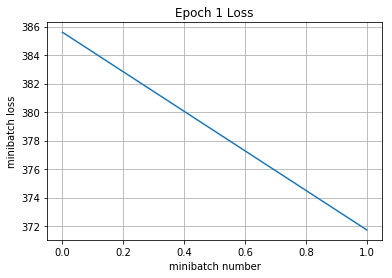

Model saved in file : checkpoint/fc_1024_mix_18
Epoch 2, Overall loss = 0.0658, accuracy of 0.978 and f1 score of 0.98
Epoch 3, Overall loss = 0.0725, accuracy of 0.974 and f1 score of 0.97
Epoch 4, Overall loss = 0.0639, accuracy of 0.977 and f1 score of 0.98
Epoch 5, Overall loss = 0.0661, accuracy of 0.976 and f1 score of 0.97
Epoch 6, Overall loss = 0.0684, accuracy of 0.976 and f1 score of 0.97
Epoch 7, Overall loss = 0.0629, accuracy of 0.979 and f1 score of 0.98
Epoch 8, Overall loss = 0.0715, accuracy of 0.973 and f1 score of 0.97
Epoch 9, Overall loss = 0.0686, accuracy of 0.976 and f1 score of 0.98
Epoch 10, Overall loss = 0.0679, accuracy of 0.976 and f1 score of 0.97
Epoch 11, Overall loss = 0.0703, accuracy of 0.974 and f1 score of 0.97
Epoch 12, Overall loss = 0.0676, accuracy of 0.976 and f1 score of 0.97
Epoch 13, Overall loss = 0.0688, accuracy of 0.976 and f1 score of 0.97
Epoch 14, Overall loss = 0.0656, accuracy of 0.977 and f1 score of 0.97
Epoch 15, Overall loss =

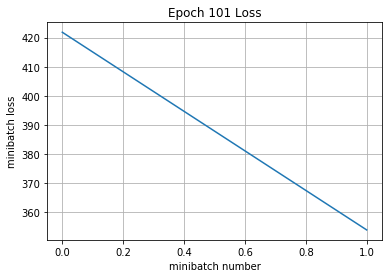

Epoch 102, Overall loss = 0.0699, accuracy of 0.975 and f1 score of 0.97
Epoch 103, Overall loss = 0.0669, accuracy of 0.977 and f1 score of 0.98
Epoch 104, Overall loss = 0.0689, accuracy of 0.977 and f1 score of 0.98
Epoch 105, Overall loss = 0.0674, accuracy of 0.977 and f1 score of 0.98
Epoch 106, Overall loss = 0.0663, accuracy of 0.978 and f1 score of 0.98
Epoch 107, Overall loss = 0.0701, accuracy of 0.975 and f1 score of 0.97
Epoch 108, Overall loss = 0.0684, accuracy of 0.976 and f1 score of 0.97
Epoch 109, Overall loss = 0.066, accuracy of 0.978 and f1 score of 0.98
Epoch 110, Overall loss = 0.0656, accuracy of 0.977 and f1 score of 0.98
Epoch 111, Overall loss = 0.0654, accuracy of 0.977 and f1 score of 0.98
Epoch 112, Overall loss = 0.067, accuracy of 0.979 and f1 score of 0.98
Epoch 113, Overall loss = 0.0678, accuracy of 0.977 and f1 score of 0.97
Epoch 114, Overall loss = 0.0621, accuracy of 0.979 and f1 score of 0.98
Epoch 115, Overall loss = 0.072, accuracy of 0.975 an

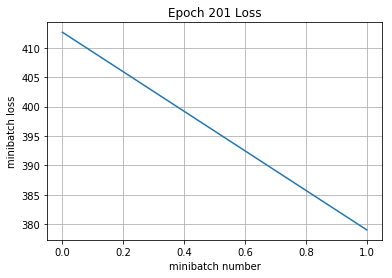

Model saved in file : checkpoint/fc_1024_mix_18
Epoch 202, Overall loss = 0.0678, accuracy of 0.976 and f1 score of 0.98
Epoch 203, Overall loss = 0.0633, accuracy of 0.979 and f1 score of 0.98
Epoch 204, Overall loss = 0.067, accuracy of 0.977 and f1 score of 0.98
Epoch 205, Overall loss = 0.0696, accuracy of 0.973 and f1 score of 0.97
Epoch 206, Overall loss = 0.0672, accuracy of 0.977 and f1 score of 0.98
Epoch 207, Overall loss = 0.066, accuracy of 0.977 and f1 score of 0.98
Epoch 208, Overall loss = 0.0675, accuracy of 0.976 and f1 score of 0.97
Epoch 209, Overall loss = 0.0679, accuracy of 0.976 and f1 score of 0.97
Epoch 210, Overall loss = 0.0704, accuracy of 0.975 and f1 score of 0.97
Epoch 211, Overall loss = 0.0672, accuracy of 0.977 and f1 score of 0.98
Epoch 212, Overall loss = 0.0682, accuracy of 0.977 and f1 score of 0.98
Epoch 213, Overall loss = 0.0676, accuracy of 0.976 and f1 score of 0.97
Epoch 214, Overall loss = 0.0706, accuracy of 0.974 and f1 score of 0.97
Epoch

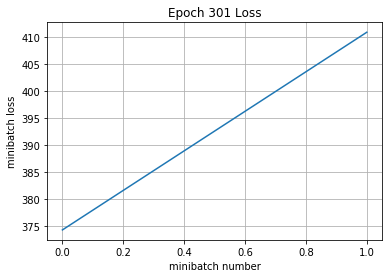

Epoch 302, Overall loss = 0.0651, accuracy of 0.978 and f1 score of 0.98
Epoch 303, Overall loss = 0.0682, accuracy of 0.977 and f1 score of 0.97
Epoch 304, Overall loss = 0.0669, accuracy of 0.975 and f1 score of 0.97
Epoch 305, Overall loss = 0.0698, accuracy of 0.975 and f1 score of 0.97
Epoch 306, Overall loss = 0.0702, accuracy of 0.976 and f1 score of 0.97
Epoch 307, Overall loss = 0.0683, accuracy of 0.977 and f1 score of 0.98
Epoch 308, Overall loss = 0.0669, accuracy of 0.978 and f1 score of 0.98
Epoch 309, Overall loss = 0.0661, accuracy of 0.976 and f1 score of 0.97
Epoch 310, Overall loss = 0.0674, accuracy of 0.976 and f1 score of 0.98
Epoch 311, Overall loss = 0.0694, accuracy of 0.976 and f1 score of 0.97
Epoch 312, Overall loss = 0.0681, accuracy of 0.977 and f1 score of 0.98
Epoch 313, Overall loss = 0.0657, accuracy of 0.977 and f1 score of 0.98
Epoch 314, Overall loss = 0.0664, accuracy of 0.977 and f1 score of 0.98
Epoch 315, Overall loss = 0.0672, accuracy of 0.977

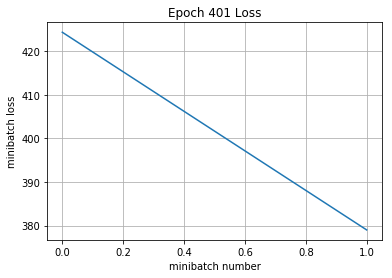

Epoch 402, Overall loss = 0.0666, accuracy of 0.977 and f1 score of 0.98
Epoch 403, Overall loss = 0.0668, accuracy of 0.975 and f1 score of 0.97
Epoch 404, Overall loss = 0.0693, accuracy of 0.976 and f1 score of 0.97
Epoch 405, Overall loss = 0.0673, accuracy of 0.977 and f1 score of 0.97
Epoch 406, Overall loss = 0.0662, accuracy of 0.978 and f1 score of 0.98
Epoch 407, Overall loss = 0.0677, accuracy of 0.977 and f1 score of 0.97
Epoch 408, Overall loss = 0.0669, accuracy of 0.976 and f1 score of 0.98
Epoch 409, Overall loss = 0.0655, accuracy of 0.978 and f1 score of 0.98
Epoch 410, Overall loss = 0.0649, accuracy of 0.977 and f1 score of 0.98
Epoch 411, Overall loss = 0.0661, accuracy of 0.976 and f1 score of 0.97
Epoch 412, Overall loss = 0.0645, accuracy of 0.979 and f1 score of 0.98
Epoch 413, Overall loss = 0.0667, accuracy of 0.976 and f1 score of 0.97
Epoch 414, Overall loss = 0.0659, accuracy of 0.976 and f1 score of 0.97
Epoch 415, Overall loss = 0.0687, accuracy of 0.976

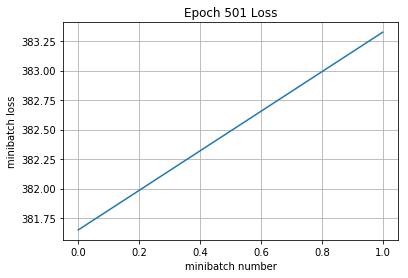

Epoch 502, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 503, Overall loss = 0.0666, accuracy of 0.978 and f1 score of 0.98
Epoch 504, Overall loss = 0.0678, accuracy of 0.977 and f1 score of 0.98
Epoch 505, Overall loss = 0.0657, accuracy of 0.978 and f1 score of 0.98
Epoch 506, Overall loss = 0.0662, accuracy of 0.977 and f1 score of 0.97
Epoch 507, Overall loss = 0.0664, accuracy of 0.976 and f1 score of 0.97
Epoch 508, Overall loss = 0.0687, accuracy of 0.976 and f1 score of 0.97
Epoch 509, Overall loss = 0.0682, accuracy of 0.976 and f1 score of 0.97
Epoch 510, Overall loss = 0.0649, accuracy of 0.978 and f1 score of 0.98
Epoch 511, Overall loss = 0.072, accuracy of 0.974 and f1 score of 0.97
Epoch 512, Overall loss = 0.0636, accuracy of 0.977 and f1 score of 0.98
Epoch 513, Overall loss = 0.0665, accuracy of 0.976 and f1 score of 0.97
Epoch 514, Overall loss = 0.0646, accuracy of 0.979 and f1 score of 0.98
Epoch 515, Overall loss = 0.0678, accuracy of 0.976 

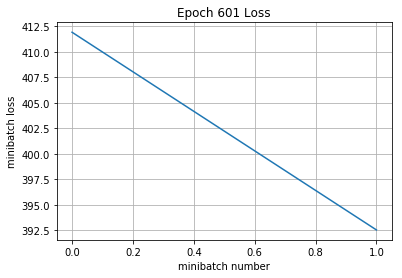

Epoch 602, Overall loss = 0.0681, accuracy of 0.976 and f1 score of 0.98
Epoch 603, Overall loss = 0.0653, accuracy of 0.977 and f1 score of 0.97
Epoch 604, Overall loss = 0.068, accuracy of 0.977 and f1 score of 0.97
Epoch 605, Overall loss = 0.0642, accuracy of 0.979 and f1 score of 0.98
Epoch 606, Overall loss = 0.066, accuracy of 0.976 and f1 score of 0.97
Epoch 607, Overall loss = 0.0659, accuracy of 0.976 and f1 score of 0.97
Epoch 608, Overall loss = 0.0638, accuracy of 0.979 and f1 score of 0.98
Epoch 609, Overall loss = 0.065, accuracy of 0.977 and f1 score of 0.98
Epoch 610, Overall loss = 0.0654, accuracy of 0.977 and f1 score of 0.97
Epoch 611, Overall loss = 0.0682, accuracy of 0.978 and f1 score of 0.98
Epoch 612, Overall loss = 0.0638, accuracy of 0.979 and f1 score of 0.98
Epoch 613, Overall loss = 0.0669, accuracy of 0.977 and f1 score of 0.98
Epoch 614, Overall loss = 0.0665, accuracy of 0.978 and f1 score of 0.98
Epoch 615, Overall loss = 0.0682, accuracy of 0.977 an

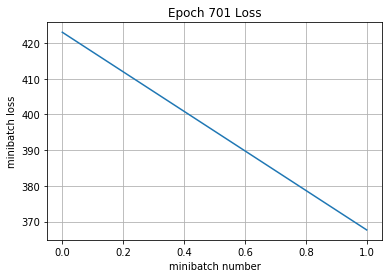

Epoch 702, Overall loss = 0.0703, accuracy of 0.975 and f1 score of 0.97
Epoch 703, Overall loss = 0.0717, accuracy of 0.976 and f1 score of 0.97
Epoch 704, Overall loss = 0.0645, accuracy of 0.978 and f1 score of 0.98
Epoch 705, Overall loss = 0.0663, accuracy of 0.976 and f1 score of 0.97
Epoch 706, Overall loss = 0.0653, accuracy of 0.978 and f1 score of 0.98
Epoch 707, Overall loss = 0.0692, accuracy of 0.975 and f1 score of 0.97
Epoch 708, Overall loss = 0.0699, accuracy of 0.976 and f1 score of 0.97
Epoch 709, Overall loss = 0.0667, accuracy of 0.976 and f1 score of 0.97
Epoch 710, Overall loss = 0.0643, accuracy of 0.978 and f1 score of 0.98
Epoch 711, Overall loss = 0.065, accuracy of 0.976 and f1 score of 0.98
Epoch 712, Overall loss = 0.067, accuracy of 0.976 and f1 score of 0.97
Epoch 713, Overall loss = 0.0664, accuracy of 0.976 and f1 score of 0.97
Epoch 714, Overall loss = 0.0691, accuracy of 0.977 and f1 score of 0.97
Epoch 715, Overall loss = 0.0666, accuracy of 0.977 a

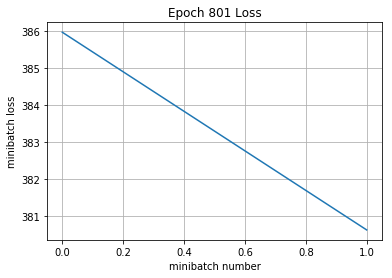

Epoch 802, Overall loss = 0.0653, accuracy of 0.977 and f1 score of 0.98
Epoch 803, Overall loss = 0.0646, accuracy of 0.976 and f1 score of 0.97
Epoch 804, Overall loss = 0.0652, accuracy of 0.978 and f1 score of 0.98
Epoch 805, Overall loss = 0.0662, accuracy of 0.976 and f1 score of 0.97
Epoch 806, Overall loss = 0.0645, accuracy of 0.978 and f1 score of 0.98
Epoch 807, Overall loss = 0.0655, accuracy of 0.977 and f1 score of 0.98
Epoch 808, Overall loss = 0.0674, accuracy of 0.977 and f1 score of 0.98
Epoch 809, Overall loss = 0.0673, accuracy of 0.977 and f1 score of 0.97
Epoch 810, Overall loss = 0.0709, accuracy of 0.973 and f1 score of 0.97
Epoch 811, Overall loss = 0.0671, accuracy of 0.977 and f1 score of 0.98
Epoch 812, Overall loss = 0.0694, accuracy of 0.976 and f1 score of 0.97
Epoch 813, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.98
Epoch 814, Overall loss = 0.0654, accuracy of 0.977 and f1 score of 0.98
Epoch 815, Overall loss = 0.067, accuracy of 0.976 

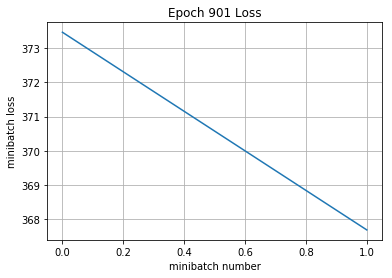

Epoch 902, Overall loss = 0.0627, accuracy of 0.979 and f1 score of 0.98
Epoch 903, Overall loss = 0.0675, accuracy of 0.975 and f1 score of 0.97
Epoch 904, Overall loss = 0.0646, accuracy of 0.978 and f1 score of 0.98
Epoch 905, Overall loss = 0.0666, accuracy of 0.977 and f1 score of 0.98
Epoch 906, Overall loss = 0.0659, accuracy of 0.977 and f1 score of 0.98
Epoch 907, Overall loss = 0.0673, accuracy of 0.976 and f1 score of 0.97
Epoch 908, Overall loss = 0.0728, accuracy of 0.974 and f1 score of 0.97
Epoch 909, Overall loss = 0.0665, accuracy of 0.977 and f1 score of 0.98
Epoch 910, Overall loss = 0.0683, accuracy of 0.976 and f1 score of 0.97
Epoch 911, Overall loss = 0.0635, accuracy of 0.978 and f1 score of 0.98
Epoch 912, Overall loss = 0.0683, accuracy of 0.976 and f1 score of 0.97
Epoch 913, Overall loss = 0.0678, accuracy of 0.976 and f1 score of 0.97
Epoch 914, Overall loss = 0.0645, accuracy of 0.976 and f1 score of 0.97
Epoch 915, Overall loss = 0.0675, accuracy of 0.976

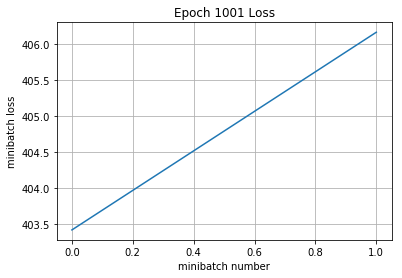

Epoch 1002, Overall loss = 0.0633, accuracy of 0.979 and f1 score of 0.98
Epoch 1003, Overall loss = 0.0662, accuracy of 0.978 and f1 score of 0.98
Epoch 1004, Overall loss = 0.0654, accuracy of 0.977 and f1 score of 0.98
Epoch 1005, Overall loss = 0.066, accuracy of 0.978 and f1 score of 0.98
Epoch 1006, Overall loss = 0.0672, accuracy of 0.977 and f1 score of 0.98
Epoch 1007, Overall loss = 0.0638, accuracy of 0.977 and f1 score of 0.97
Epoch 1008, Overall loss = 0.0664, accuracy of 0.976 and f1 score of 0.97
Epoch 1009, Overall loss = 0.0693, accuracy of 0.976 and f1 score of 0.97
Epoch 1010, Overall loss = 0.0668, accuracy of 0.978 and f1 score of 0.98
Epoch 1011, Overall loss = 0.0656, accuracy of 0.978 and f1 score of 0.98
Epoch 1012, Overall loss = 0.0649, accuracy of 0.978 and f1 score of 0.98
Epoch 1013, Overall loss = 0.0686, accuracy of 0.974 and f1 score of 0.97
Epoch 1014, Overall loss = 0.067, accuracy of 0.978 and f1 score of 0.98
Epoch 1015, Overall loss = 0.0647, accur

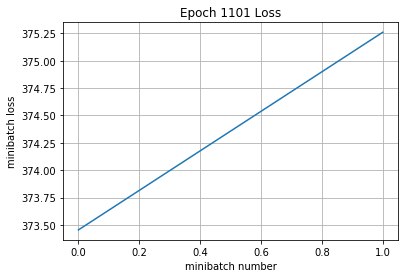

Epoch 1102, Overall loss = 0.068, accuracy of 0.977 and f1 score of 0.97
Epoch 1103, Overall loss = 0.0657, accuracy of 0.977 and f1 score of 0.98
Epoch 1104, Overall loss = 0.0665, accuracy of 0.976 and f1 score of 0.97
Epoch 1105, Overall loss = 0.0672, accuracy of 0.976 and f1 score of 0.97
Epoch 1106, Overall loss = 0.0695, accuracy of 0.976 and f1 score of 0.97
Epoch 1107, Overall loss = 0.0662, accuracy of 0.976 and f1 score of 0.97
Epoch 1108, Overall loss = 0.0639, accuracy of 0.978 and f1 score of 0.98
Epoch 1109, Overall loss = 0.0646, accuracy of 0.978 and f1 score of 0.98
Epoch 1110, Overall loss = 0.0646, accuracy of 0.977 and f1 score of 0.97
Epoch 1111, Overall loss = 0.0679, accuracy of 0.975 and f1 score of 0.97
Epoch 1112, Overall loss = 0.069, accuracy of 0.976 and f1 score of 0.97
Epoch 1113, Overall loss = 0.0649, accuracy of 0.978 and f1 score of 0.98
Epoch 1114, Overall loss = 0.0678, accuracy of 0.976 and f1 score of 0.97
Epoch 1115, Overall loss = 0.0659, accur

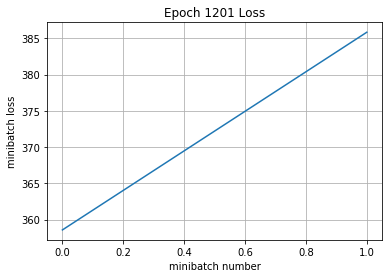

Epoch 1202, Overall loss = 0.0667, accuracy of 0.978 and f1 score of 0.98
Epoch 1203, Overall loss = 0.0658, accuracy of 0.977 and f1 score of 0.98
Epoch 1204, Overall loss = 0.0657, accuracy of 0.977 and f1 score of 0.97
Epoch 1205, Overall loss = 0.0646, accuracy of 0.978 and f1 score of 0.98
Epoch 1206, Overall loss = 0.0665, accuracy of 0.976 and f1 score of 0.97
Epoch 1207, Overall loss = 0.0695, accuracy of 0.975 and f1 score of 0.97
Epoch 1208, Overall loss = 0.067, accuracy of 0.976 and f1 score of 0.97
Epoch 1209, Overall loss = 0.0661, accuracy of 0.979 and f1 score of 0.98
Epoch 1210, Overall loss = 0.0651, accuracy of 0.979 and f1 score of 0.98
Epoch 1211, Overall loss = 0.0665, accuracy of 0.976 and f1 score of 0.97
Epoch 1212, Overall loss = 0.0679, accuracy of 0.977 and f1 score of 0.97
Epoch 1213, Overall loss = 0.0654, accuracy of 0.978 and f1 score of 0.98
Epoch 1214, Overall loss = 0.0684, accuracy of 0.978 and f1 score of 0.98
Epoch 1215, Overall loss = 0.067, accur

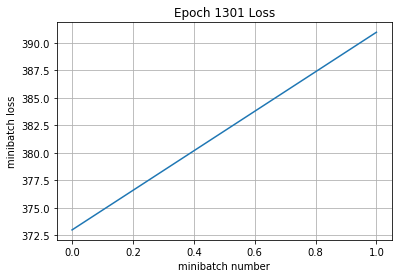

Epoch 1302, Overall loss = 0.0652, accuracy of 0.976 and f1 score of 0.97
Epoch 1303, Overall loss = 0.0654, accuracy of 0.977 and f1 score of 0.97
Epoch 1304, Overall loss = 0.0671, accuracy of 0.976 and f1 score of 0.97
Epoch 1305, Overall loss = 0.0685, accuracy of 0.975 and f1 score of 0.97
Epoch 1306, Overall loss = 0.0633, accuracy of 0.979 and f1 score of 0.98
Epoch 1307, Overall loss = 0.0644, accuracy of 0.978 and f1 score of 0.98
Epoch 1308, Overall loss = 0.0681, accuracy of 0.975 and f1 score of 0.97
Epoch 1309, Overall loss = 0.0669, accuracy of 0.976 and f1 score of 0.98
Epoch 1310, Overall loss = 0.0689, accuracy of 0.975 and f1 score of 0.97
Epoch 1311, Overall loss = 0.0682, accuracy of 0.976 and f1 score of 0.97
Epoch 1312, Overall loss = 0.0653, accuracy of 0.978 and f1 score of 0.98
Epoch 1313, Overall loss = 0.0663, accuracy of 0.977 and f1 score of 0.98
Epoch 1314, Overall loss = 0.067, accuracy of 0.976 and f1 score of 0.98
Epoch 1315, Overall loss = 0.0656, accu

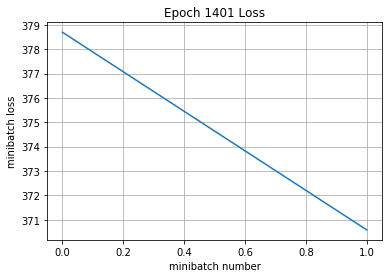

Epoch 1402, Overall loss = 0.0661, accuracy of 0.976 and f1 score of 0.97
Epoch 1403, Overall loss = 0.0627, accuracy of 0.978 and f1 score of 0.98
Epoch 1404, Overall loss = 0.0653, accuracy of 0.977 and f1 score of 0.97
Epoch 1405, Overall loss = 0.0664, accuracy of 0.977 and f1 score of 0.97
Epoch 1406, Overall loss = 0.0656, accuracy of 0.978 and f1 score of 0.98
Epoch 1407, Overall loss = 0.066, accuracy of 0.976 and f1 score of 0.98
Epoch 1408, Overall loss = 0.0694, accuracy of 0.975 and f1 score of 0.97
Epoch 1409, Overall loss = 0.0665, accuracy of 0.976 and f1 score of 0.97
Epoch 1410, Overall loss = 0.0643, accuracy of 0.978 and f1 score of 0.98
Epoch 1411, Overall loss = 0.0699, accuracy of 0.975 and f1 score of 0.97
Epoch 1412, Overall loss = 0.0631, accuracy of 0.979 and f1 score of 0.98
Epoch 1413, Overall loss = 0.0666, accuracy of 0.977 and f1 score of 0.97
Epoch 1414, Overall loss = 0.0673, accuracy of 0.977 and f1 score of 0.97
Epoch 1415, Overall loss = 0.0692, accu

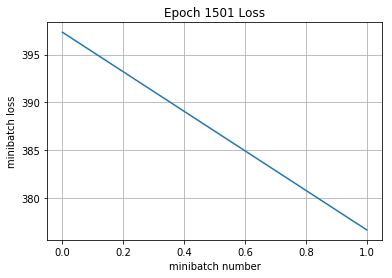

Epoch 1502, Overall loss = 0.0615, accuracy of 0.979 and f1 score of 0.98
Epoch 1503, Overall loss = 0.0654, accuracy of 0.977 and f1 score of 0.98
Epoch 1504, Overall loss = 0.0683, accuracy of 0.977 and f1 score of 0.98
Epoch 1505, Overall loss = 0.0641, accuracy of 0.978 and f1 score of 0.98
Epoch 1506, Overall loss = 0.0679, accuracy of 0.976 and f1 score of 0.97
Epoch 1507, Overall loss = 0.0663, accuracy of 0.977 and f1 score of 0.97
Epoch 1508, Overall loss = 0.0676, accuracy of 0.975 and f1 score of 0.97
Epoch 1509, Overall loss = 0.063, accuracy of 0.978 and f1 score of 0.98
Epoch 1510, Overall loss = 0.0673, accuracy of 0.975 and f1 score of 0.97
Epoch 1511, Overall loss = 0.0682, accuracy of 0.976 and f1 score of 0.97
Epoch 1512, Overall loss = 0.0666, accuracy of 0.977 and f1 score of 0.98
Epoch 1513, Overall loss = 0.0695, accuracy of 0.975 and f1 score of 0.97
Epoch 1514, Overall loss = 0.067, accuracy of 0.975 and f1 score of 0.97
Epoch 1515, Overall loss = 0.0626, accur

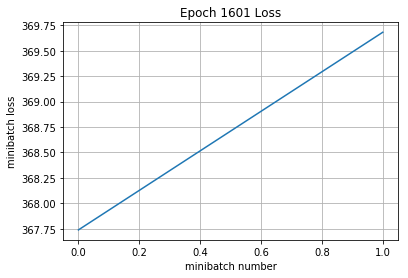

Epoch 1602, Overall loss = 0.0641, accuracy of 0.979 and f1 score of 0.98
Epoch 1603, Overall loss = 0.065, accuracy of 0.977 and f1 score of 0.97
Epoch 1604, Overall loss = 0.0653, accuracy of 0.976 and f1 score of 0.98
Epoch 1605, Overall loss = 0.0678, accuracy of 0.977 and f1 score of 0.98
Epoch 1606, Overall loss = 0.0668, accuracy of 0.975 and f1 score of 0.97
Epoch 1607, Overall loss = 0.063, accuracy of 0.978 and f1 score of 0.98
Epoch 1608, Overall loss = 0.0689, accuracy of 0.975 and f1 score of 0.97
Epoch 1609, Overall loss = 0.0656, accuracy of 0.977 and f1 score of 0.97
Epoch 1610, Overall loss = 0.0638, accuracy of 0.977 and f1 score of 0.98
Epoch 1611, Overall loss = 0.0645, accuracy of 0.977 and f1 score of 0.98
Epoch 1612, Overall loss = 0.0649, accuracy of 0.977 and f1 score of 0.97
Epoch 1613, Overall loss = 0.0672, accuracy of 0.976 and f1 score of 0.97
Epoch 1614, Overall loss = 0.0665, accuracy of 0.978 and f1 score of 0.98
Epoch 1615, Overall loss = 0.0665, accur

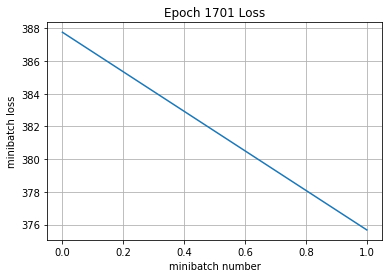

Epoch 1702, Overall loss = 0.0675, accuracy of 0.976 and f1 score of 0.98
Epoch 1703, Overall loss = 0.0665, accuracy of 0.977 and f1 score of 0.97
Epoch 1704, Overall loss = 0.0671, accuracy of 0.977 and f1 score of 0.98
Epoch 1705, Overall loss = 0.0631, accuracy of 0.977 and f1 score of 0.97
Epoch 1706, Overall loss = 0.0682, accuracy of 0.976 and f1 score of 0.98
Epoch 1707, Overall loss = 0.065, accuracy of 0.976 and f1 score of 0.97
Epoch 1708, Overall loss = 0.0637, accuracy of 0.977 and f1 score of 0.98
Epoch 1709, Overall loss = 0.0662, accuracy of 0.977 and f1 score of 0.98
Epoch 1710, Overall loss = 0.0678, accuracy of 0.977 and f1 score of 0.98
Epoch 1711, Overall loss = 0.0676, accuracy of 0.976 and f1 score of 0.97
Epoch 1712, Overall loss = 0.0676, accuracy of 0.975 and f1 score of 0.97
Epoch 1713, Overall loss = 0.064, accuracy of 0.978 and f1 score of 0.98
Epoch 1714, Overall loss = 0.0657, accuracy of 0.977 and f1 score of 0.98
Epoch 1715, Overall loss = 0.0673, accur

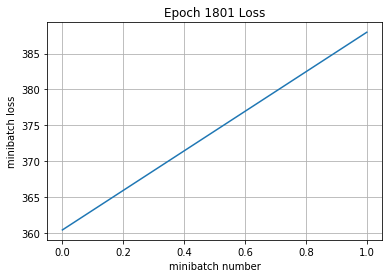

Epoch 1802, Overall loss = 0.067, accuracy of 0.977 and f1 score of 0.98
Epoch 1803, Overall loss = 0.0657, accuracy of 0.975 and f1 score of 0.97
Epoch 1804, Overall loss = 0.0671, accuracy of 0.974 and f1 score of 0.97
Epoch 1805, Overall loss = 0.0691, accuracy of 0.975 and f1 score of 0.97
Epoch 1806, Overall loss = 0.0688, accuracy of 0.976 and f1 score of 0.98
Epoch 1807, Overall loss = 0.068, accuracy of 0.977 and f1 score of 0.98
Epoch 1808, Overall loss = 0.0638, accuracy of 0.978 and f1 score of 0.98
Epoch 1809, Overall loss = 0.0656, accuracy of 0.976 and f1 score of 0.97
Epoch 1810, Overall loss = 0.0649, accuracy of 0.977 and f1 score of 0.98
Epoch 1811, Overall loss = 0.0653, accuracy of 0.978 and f1 score of 0.98
Epoch 1812, Overall loss = 0.0671, accuracy of 0.976 and f1 score of 0.97
Epoch 1813, Overall loss = 0.0649, accuracy of 0.977 and f1 score of 0.97
Epoch 1814, Overall loss = 0.0644, accuracy of 0.978 and f1 score of 0.98
Epoch 1815, Overall loss = 0.07, accurac

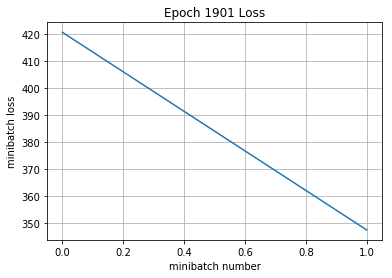

Epoch 1902, Overall loss = 0.065, accuracy of 0.977 and f1 score of 0.97
Epoch 1903, Overall loss = 0.0663, accuracy of 0.977 and f1 score of 0.97
Epoch 1904, Overall loss = 0.0641, accuracy of 0.978 and f1 score of 0.98
Epoch 1905, Overall loss = 0.0625, accuracy of 0.979 and f1 score of 0.98
Epoch 1906, Overall loss = 0.0677, accuracy of 0.976 and f1 score of 0.98
Epoch 1907, Overall loss = 0.0661, accuracy of 0.978 and f1 score of 0.98
Epoch 1908, Overall loss = 0.0656, accuracy of 0.978 and f1 score of 0.98
Epoch 1909, Overall loss = 0.0688, accuracy of 0.975 and f1 score of 0.97
Epoch 1910, Overall loss = 0.0638, accuracy of 0.979 and f1 score of 0.98
Epoch 1911, Overall loss = 0.0667, accuracy of 0.977 and f1 score of 0.97
Epoch 1912, Overall loss = 0.0665, accuracy of 0.978 and f1 score of 0.98
Epoch 1913, Overall loss = 0.066, accuracy of 0.978 and f1 score of 0.98
Epoch 1914, Overall loss = 0.0682, accuracy of 0.975 and f1 score of 0.97
Epoch 1915, Overall loss = 0.0677, accur

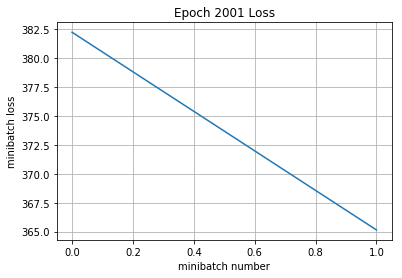

Epoch 2002, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 2003, Overall loss = 0.0651, accuracy of 0.977 and f1 score of 0.98
Epoch 2004, Overall loss = 0.0665, accuracy of 0.978 and f1 score of 0.98
Epoch 2005, Overall loss = 0.0672, accuracy of 0.977 and f1 score of 0.98
Epoch 2006, Overall loss = 0.0673, accuracy of 0.977 and f1 score of 0.98
Epoch 2007, Overall loss = 0.0643, accuracy of 0.977 and f1 score of 0.98
Epoch 2008, Overall loss = 0.0644, accuracy of 0.977 and f1 score of 0.97
Epoch 2009, Overall loss = 0.0633, accuracy of 0.978 and f1 score of 0.98
Epoch 2010, Overall loss = 0.0661, accuracy of 0.977 and f1 score of 0.98
Epoch 2011, Overall loss = 0.0672, accuracy of 0.976 and f1 score of 0.97
Epoch 2012, Overall loss = 0.0663, accuracy of 0.977 and f1 score of 0.98
Epoch 2013, Overall loss = 0.0666, accuracy of 0.978 and f1 score of 0.98
Epoch 2014, Overall loss = 0.063, accuracy of 0.978 and f1 score of 0.98
Epoch 2015, Overall loss = 0.0658, accu

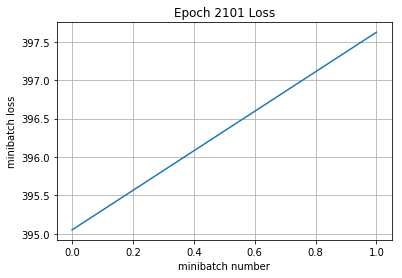

Epoch 2102, Overall loss = 0.0641, accuracy of 0.978 and f1 score of 0.98
Epoch 2103, Overall loss = 0.0668, accuracy of 0.977 and f1 score of 0.98
Epoch 2104, Overall loss = 0.0679, accuracy of 0.976 and f1 score of 0.97
Epoch 2105, Overall loss = 0.0652, accuracy of 0.977 and f1 score of 0.97
Epoch 2106, Overall loss = 0.0685, accuracy of 0.975 and f1 score of 0.97
Epoch 2107, Overall loss = 0.0659, accuracy of 0.976 and f1 score of 0.97
Epoch 2108, Overall loss = 0.068, accuracy of 0.975 and f1 score of 0.97
Epoch 2109, Overall loss = 0.0642, accuracy of 0.978 and f1 score of 0.98
Epoch 2110, Overall loss = 0.0616, accuracy of 0.978 and f1 score of 0.98
Epoch 2111, Overall loss = 0.0638, accuracy of 0.978 and f1 score of 0.98
Epoch 2112, Overall loss = 0.0666, accuracy of 0.975 and f1 score of 0.97
Epoch 2113, Overall loss = 0.0634, accuracy of 0.978 and f1 score of 0.98
Epoch 2114, Overall loss = 0.0646, accuracy of 0.978 and f1 score of 0.98
Epoch 2115, Overall loss = 0.0646, accu

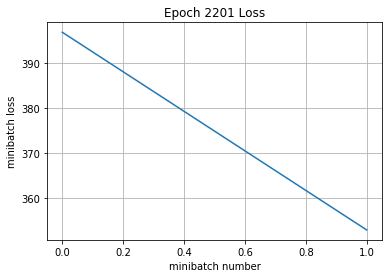

Epoch 2202, Overall loss = 0.0669, accuracy of 0.976 and f1 score of 0.98
Epoch 2203, Overall loss = 0.0664, accuracy of 0.977 and f1 score of 0.98
Epoch 2204, Overall loss = 0.0639, accuracy of 0.978 and f1 score of 0.97
Epoch 2205, Overall loss = 0.0668, accuracy of 0.976 and f1 score of 0.98
Epoch 2206, Overall loss = 0.066, accuracy of 0.977 and f1 score of 0.97
Epoch 2207, Overall loss = 0.0654, accuracy of 0.976 and f1 score of 0.97
Epoch 2208, Overall loss = 0.0664, accuracy of 0.978 and f1 score of 0.98
Epoch 2209, Overall loss = 0.0653, accuracy of 0.977 and f1 score of 0.98
Epoch 2210, Overall loss = 0.0628, accuracy of 0.978 and f1 score of 0.98
Epoch 2211, Overall loss = 0.0644, accuracy of 0.978 and f1 score of 0.98
Epoch 2212, Overall loss = 0.0661, accuracy of 0.977 and f1 score of 0.98
Epoch 2213, Overall loss = 0.0637, accuracy of 0.977 and f1 score of 0.98
Epoch 2214, Overall loss = 0.064, accuracy of 0.978 and f1 score of 0.98
Epoch 2215, Overall loss = 0.0658, accur

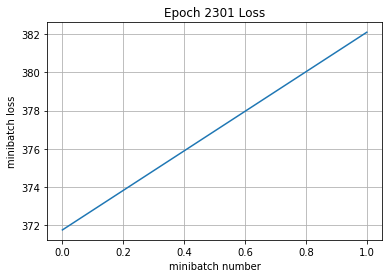

Epoch 2302, Overall loss = 0.0614, accuracy of 0.979 and f1 score of 0.98
Epoch 2303, Overall loss = 0.0635, accuracy of 0.979 and f1 score of 0.98
Epoch 2304, Overall loss = 0.0659, accuracy of 0.976 and f1 score of 0.97
Epoch 2305, Overall loss = 0.0664, accuracy of 0.976 and f1 score of 0.98
Epoch 2306, Overall loss = 0.0671, accuracy of 0.976 and f1 score of 0.97
Epoch 2307, Overall loss = 0.0655, accuracy of 0.979 and f1 score of 0.98
Epoch 2308, Overall loss = 0.0675, accuracy of 0.975 and f1 score of 0.97
Epoch 2309, Overall loss = 0.0618, accuracy of 0.979 and f1 score of 0.98
Epoch 2310, Overall loss = 0.0647, accuracy of 0.979 and f1 score of 0.98
Epoch 2311, Overall loss = 0.0651, accuracy of 0.976 and f1 score of 0.97
Epoch 2312, Overall loss = 0.0662, accuracy of 0.978 and f1 score of 0.98
Epoch 2313, Overall loss = 0.0643, accuracy of 0.978 and f1 score of 0.98
Epoch 2314, Overall loss = 0.0635, accuracy of 0.978 and f1 score of 0.98
Epoch 2315, Overall loss = 0.0652, acc

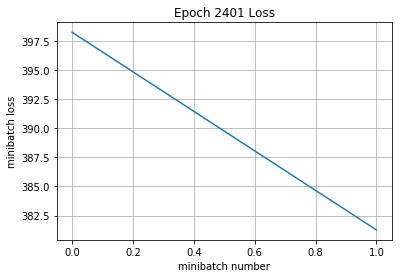

Epoch 2402, Overall loss = 0.0678, accuracy of 0.975 and f1 score of 0.97
Epoch 2403, Overall loss = 0.0621, accuracy of 0.978 and f1 score of 0.98
Epoch 2404, Overall loss = 0.0665, accuracy of 0.978 and f1 score of 0.98
Epoch 2405, Overall loss = 0.0636, accuracy of 0.979 and f1 score of 0.98
Epoch 2406, Overall loss = 0.066, accuracy of 0.977 and f1 score of 0.98
Epoch 2407, Overall loss = 0.0701, accuracy of 0.976 and f1 score of 0.97
Epoch 2408, Overall loss = 0.0659, accuracy of 0.977 and f1 score of 0.98
Epoch 2409, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.98
Epoch 2410, Overall loss = 0.065, accuracy of 0.978 and f1 score of 0.98
Epoch 2411, Overall loss = 0.0627, accuracy of 0.978 and f1 score of 0.98
Epoch 2412, Overall loss = 0.0648, accuracy of 0.976 and f1 score of 0.97
Epoch 2413, Overall loss = 0.0657, accuracy of 0.977 and f1 score of 0.98
Epoch 2414, Overall loss = 0.0664, accuracy of 0.976 and f1 score of 0.97
Epoch 2415, Overall loss = 0.067, accura

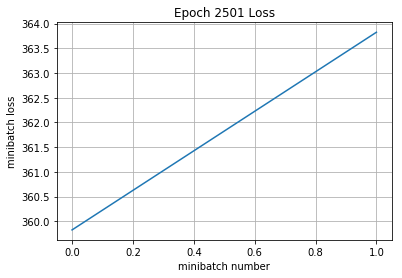

Epoch 2502, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.98
Epoch 2503, Overall loss = 0.0652, accuracy of 0.977 and f1 score of 0.98
Epoch 2504, Overall loss = 0.065, accuracy of 0.978 and f1 score of 0.98
Epoch 2505, Overall loss = 0.0638, accuracy of 0.978 and f1 score of 0.98
Epoch 2506, Overall loss = 0.0676, accuracy of 0.975 and f1 score of 0.97
Epoch 2507, Overall loss = 0.0622, accuracy of 0.977 and f1 score of 0.98
Epoch 2508, Overall loss = 0.0655, accuracy of 0.977 and f1 score of 0.97
Epoch 2509, Overall loss = 0.0649, accuracy of 0.977 and f1 score of 0.98
Epoch 2510, Overall loss = 0.0646, accuracy of 0.978 and f1 score of 0.98
Epoch 2511, Overall loss = 0.0637, accuracy of 0.977 and f1 score of 0.98
Epoch 2512, Overall loss = 0.0676, accuracy of 0.975 and f1 score of 0.97
Epoch 2513, Overall loss = 0.0677, accuracy of 0.976 and f1 score of 0.97
Epoch 2514, Overall loss = 0.0631, accuracy of 0.977 and f1 score of 0.97
Epoch 2515, Overall loss = 0.0614, accu

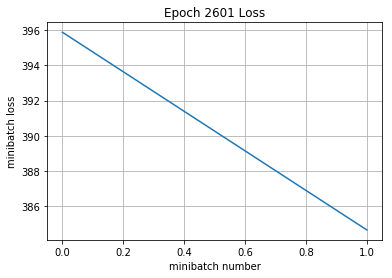

Epoch 2602, Overall loss = 0.0668, accuracy of 0.975 and f1 score of 0.97
Epoch 2603, Overall loss = 0.0656, accuracy of 0.976 and f1 score of 0.98
Epoch 2604, Overall loss = 0.0638, accuracy of 0.977 and f1 score of 0.98
Epoch 2605, Overall loss = 0.0659, accuracy of 0.975 and f1 score of 0.97
Epoch 2606, Overall loss = 0.0643, accuracy of 0.976 and f1 score of 0.97
Epoch 2607, Overall loss = 0.066, accuracy of 0.975 and f1 score of 0.97
Epoch 2608, Overall loss = 0.0672, accuracy of 0.976 and f1 score of 0.97
Epoch 2609, Overall loss = 0.0677, accuracy of 0.977 and f1 score of 0.97
Epoch 2610, Overall loss = 0.0634, accuracy of 0.978 and f1 score of 0.97
Epoch 2611, Overall loss = 0.0644, accuracy of 0.977 and f1 score of 0.97
Epoch 2612, Overall loss = 0.0675, accuracy of 0.976 and f1 score of 0.98
Epoch 2613, Overall loss = 0.0648, accuracy of 0.977 and f1 score of 0.98
Epoch 2614, Overall loss = 0.0619, accuracy of 0.98 and f1 score of 0.98
Epoch 2615, Overall loss = 0.066, accura

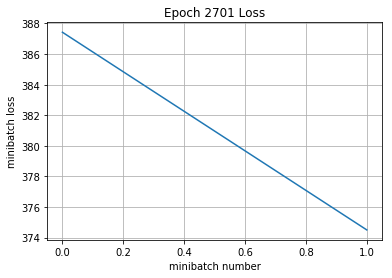

Epoch 2702, Overall loss = 0.0659, accuracy of 0.978 and f1 score of 0.98
Epoch 2703, Overall loss = 0.0642, accuracy of 0.976 and f1 score of 0.97
Epoch 2704, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 2705, Overall loss = 0.0651, accuracy of 0.977 and f1 score of 0.98
Epoch 2706, Overall loss = 0.0649, accuracy of 0.977 and f1 score of 0.97
Epoch 2707, Overall loss = 0.0634, accuracy of 0.979 and f1 score of 0.98
Epoch 2708, Overall loss = 0.0647, accuracy of 0.977 and f1 score of 0.98
Epoch 2709, Overall loss = 0.0608, accuracy of 0.979 and f1 score of 0.98
Epoch 2710, Overall loss = 0.0675, accuracy of 0.977 and f1 score of 0.98
Epoch 2711, Overall loss = 0.0646, accuracy of 0.978 and f1 score of 0.98
Epoch 2712, Overall loss = 0.0618, accuracy of 0.978 and f1 score of 0.98
Epoch 2713, Overall loss = 0.0679, accuracy of 0.976 and f1 score of 0.97
Epoch 2714, Overall loss = 0.0624, accuracy of 0.978 and f1 score of 0.98
Epoch 2715, Overall loss = 0.064, accu

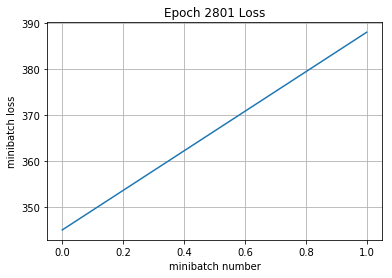

Epoch 2802, Overall loss = 0.0637, accuracy of 0.977 and f1 score of 0.98
Epoch 2803, Overall loss = 0.0646, accuracy of 0.977 and f1 score of 0.97
Epoch 2804, Overall loss = 0.067, accuracy of 0.976 and f1 score of 0.97
Epoch 2805, Overall loss = 0.0656, accuracy of 0.978 and f1 score of 0.98
Epoch 2806, Overall loss = 0.0594, accuracy of 0.979 and f1 score of 0.98
Epoch 2807, Overall loss = 0.0622, accuracy of 0.979 and f1 score of 0.98
Epoch 2808, Overall loss = 0.0646, accuracy of 0.976 and f1 score of 0.97
Epoch 2809, Overall loss = 0.064, accuracy of 0.979 and f1 score of 0.98
Epoch 2810, Overall loss = 0.0679, accuracy of 0.975 and f1 score of 0.97
Epoch 2811, Overall loss = 0.0643, accuracy of 0.978 and f1 score of 0.98
Epoch 2812, Overall loss = 0.0656, accuracy of 0.977 and f1 score of 0.97
Epoch 2813, Overall loss = 0.0645, accuracy of 0.979 and f1 score of 0.98
Epoch 2814, Overall loss = 0.0636, accuracy of 0.978 and f1 score of 0.98
Epoch 2815, Overall loss = 0.0642, accur

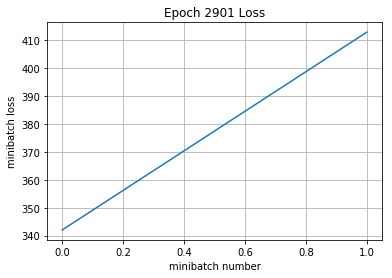

Epoch 2902, Overall loss = 0.0642, accuracy of 0.978 and f1 score of 0.98
Epoch 2903, Overall loss = 0.0653, accuracy of 0.976 and f1 score of 0.97
Epoch 2904, Overall loss = 0.0653, accuracy of 0.976 and f1 score of 0.98
Epoch 2905, Overall loss = 0.063, accuracy of 0.979 and f1 score of 0.98
Epoch 2906, Overall loss = 0.065, accuracy of 0.978 and f1 score of 0.98
Epoch 2907, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 2908, Overall loss = 0.0614, accuracy of 0.979 and f1 score of 0.98
Epoch 2909, Overall loss = 0.066, accuracy of 0.978 and f1 score of 0.98
Epoch 2910, Overall loss = 0.0656, accuracy of 0.976 and f1 score of 0.97
Epoch 2911, Overall loss = 0.0636, accuracy of 0.978 and f1 score of 0.98
Epoch 2912, Overall loss = 0.0673, accuracy of 0.976 and f1 score of 0.98
Epoch 2913, Overall loss = 0.0625, accuracy of 0.979 and f1 score of 0.98
Epoch 2914, Overall loss = 0.0617, accuracy of 0.98 and f1 score of 0.98
Epoch 2915, Overall loss = 0.0622, accurac

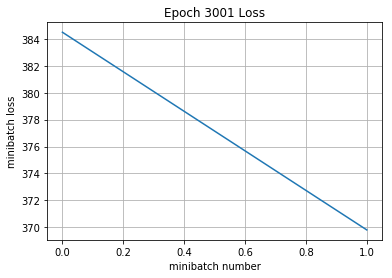

Epoch 3002, Overall loss = 0.0684, accuracy of 0.975 and f1 score of 0.97
Epoch 3003, Overall loss = 0.0642, accuracy of 0.976 and f1 score of 0.97
Epoch 3004, Overall loss = 0.0635, accuracy of 0.978 and f1 score of 0.98
Epoch 3005, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.98
Epoch 3006, Overall loss = 0.0665, accuracy of 0.977 and f1 score of 0.97
Epoch 3007, Overall loss = 0.068, accuracy of 0.976 and f1 score of 0.97
Epoch 3008, Overall loss = 0.061, accuracy of 0.979 and f1 score of 0.98
Epoch 3009, Overall loss = 0.0651, accuracy of 0.976 and f1 score of 0.97
Epoch 3010, Overall loss = 0.0622, accuracy of 0.979 and f1 score of 0.98
Epoch 3011, Overall loss = 0.0677, accuracy of 0.976 and f1 score of 0.97
Epoch 3012, Overall loss = 0.0632, accuracy of 0.978 and f1 score of 0.98
Epoch 3013, Overall loss = 0.0667, accuracy of 0.977 and f1 score of 0.98
Epoch 3014, Overall loss = 0.0629, accuracy of 0.977 and f1 score of 0.98
Epoch 3015, Overall loss = 0.0639, accur

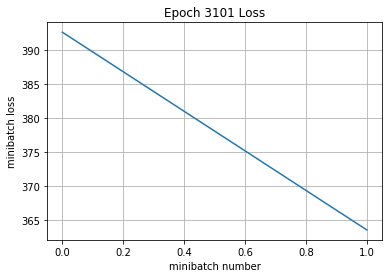

Epoch 3102, Overall loss = 0.0617, accuracy of 0.979 and f1 score of 0.98
Epoch 3103, Overall loss = 0.0701, accuracy of 0.974 and f1 score of 0.97
Epoch 3104, Overall loss = 0.0643, accuracy of 0.977 and f1 score of 0.98
Epoch 3105, Overall loss = 0.0632, accuracy of 0.978 and f1 score of 0.98
Epoch 3106, Overall loss = 0.0593, accuracy of 0.979 and f1 score of 0.98
Epoch 3107, Overall loss = 0.0613, accuracy of 0.978 and f1 score of 0.98
Epoch 3108, Overall loss = 0.0644, accuracy of 0.978 and f1 score of 0.98
Epoch 3109, Overall loss = 0.0653, accuracy of 0.977 and f1 score of 0.98
Epoch 3110, Overall loss = 0.0633, accuracy of 0.978 and f1 score of 0.98
Epoch 3111, Overall loss = 0.064, accuracy of 0.978 and f1 score of 0.98
Epoch 3112, Overall loss = 0.0599, accuracy of 0.98 and f1 score of 0.98
Epoch 3113, Overall loss = 0.0656, accuracy of 0.977 and f1 score of 0.98
Epoch 3114, Overall loss = 0.0648, accuracy of 0.977 and f1 score of 0.98
Epoch 3115, Overall loss = 0.0661, accur

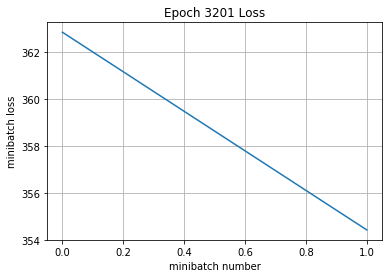

Epoch 3202, Overall loss = 0.0629, accuracy of 0.979 and f1 score of 0.98
Epoch 3203, Overall loss = 0.0647, accuracy of 0.976 and f1 score of 0.97
Epoch 3204, Overall loss = 0.0589, accuracy of 0.98 and f1 score of 0.98
Epoch 3205, Overall loss = 0.0615, accuracy of 0.978 and f1 score of 0.97
Epoch 3206, Overall loss = 0.0618, accuracy of 0.978 and f1 score of 0.98
Epoch 3207, Overall loss = 0.0643, accuracy of 0.977 and f1 score of 0.98
Epoch 3208, Overall loss = 0.0614, accuracy of 0.98 and f1 score of 0.98
Epoch 3209, Overall loss = 0.0626, accuracy of 0.979 and f1 score of 0.98
Epoch 3210, Overall loss = 0.0653, accuracy of 0.977 and f1 score of 0.98
Epoch 3211, Overall loss = 0.0603, accuracy of 0.98 and f1 score of 0.98
Epoch 3212, Overall loss = 0.0659, accuracy of 0.977 and f1 score of 0.98
Epoch 3213, Overall loss = 0.0645, accuracy of 0.977 and f1 score of 0.98
Epoch 3214, Overall loss = 0.061, accuracy of 0.979 and f1 score of 0.98
Epoch 3215, Overall loss = 0.0631, accurac

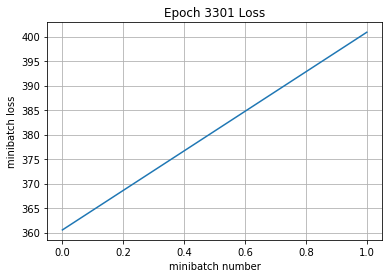

Epoch 3302, Overall loss = 0.066, accuracy of 0.976 and f1 score of 0.97
Epoch 3303, Overall loss = 0.0625, accuracy of 0.98 and f1 score of 0.98
Epoch 3304, Overall loss = 0.065, accuracy of 0.978 and f1 score of 0.97
Epoch 3305, Overall loss = 0.0661, accuracy of 0.977 and f1 score of 0.97
Epoch 3306, Overall loss = 0.0607, accuracy of 0.98 and f1 score of 0.98
Epoch 3307, Overall loss = 0.0656, accuracy of 0.976 and f1 score of 0.97
Epoch 3308, Overall loss = 0.0647, accuracy of 0.977 and f1 score of 0.97
Epoch 3309, Overall loss = 0.063, accuracy of 0.979 and f1 score of 0.98
Epoch 3310, Overall loss = 0.0684, accuracy of 0.975 and f1 score of 0.97
Epoch 3311, Overall loss = 0.0655, accuracy of 0.977 and f1 score of 0.97
Epoch 3312, Overall loss = 0.0653, accuracy of 0.978 and f1 score of 0.98
Epoch 3313, Overall loss = 0.0621, accuracy of 0.98 and f1 score of 0.98
Epoch 3314, Overall loss = 0.0619, accuracy of 0.979 and f1 score of 0.98
Epoch 3315, Overall loss = 0.0671, accuracy 

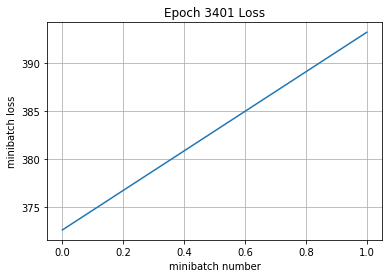

Epoch 3402, Overall loss = 0.0643, accuracy of 0.978 and f1 score of 0.98
Epoch 3403, Overall loss = 0.0617, accuracy of 0.978 and f1 score of 0.98
Epoch 3404, Overall loss = 0.0611, accuracy of 0.979 and f1 score of 0.98
Epoch 3405, Overall loss = 0.0658, accuracy of 0.977 and f1 score of 0.97
Epoch 3406, Overall loss = 0.0606, accuracy of 0.978 and f1 score of 0.98
Epoch 3407, Overall loss = 0.0638, accuracy of 0.979 and f1 score of 0.98
Epoch 3408, Overall loss = 0.0612, accuracy of 0.979 and f1 score of 0.98
Epoch 3409, Overall loss = 0.0641, accuracy of 0.977 and f1 score of 0.97
Epoch 3410, Overall loss = 0.0597, accuracy of 0.98 and f1 score of 0.98
Epoch 3411, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 3412, Overall loss = 0.0642, accuracy of 0.978 and f1 score of 0.98
Epoch 3413, Overall loss = 0.063, accuracy of 0.979 and f1 score of 0.98
Epoch 3414, Overall loss = 0.063, accuracy of 0.977 and f1 score of 0.97
Epoch 3415, Overall loss = 0.065, accurac

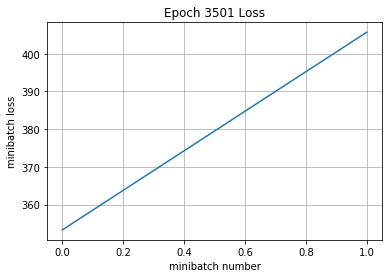

Epoch 3502, Overall loss = 0.0623, accuracy of 0.978 and f1 score of 0.98
Epoch 3503, Overall loss = 0.0685, accuracy of 0.975 and f1 score of 0.97
Epoch 3504, Overall loss = 0.0642, accuracy of 0.977 and f1 score of 0.98
Epoch 3505, Overall loss = 0.0597, accuracy of 0.98 and f1 score of 0.98
Epoch 3506, Overall loss = 0.0657, accuracy of 0.976 and f1 score of 0.97
Epoch 3507, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 3508, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 3509, Overall loss = 0.0618, accuracy of 0.978 and f1 score of 0.98
Epoch 3510, Overall loss = 0.0613, accuracy of 0.98 and f1 score of 0.98
Epoch 3511, Overall loss = 0.0626, accuracy of 0.977 and f1 score of 0.98
Epoch 3512, Overall loss = 0.0656, accuracy of 0.976 and f1 score of 0.98
Epoch 3513, Overall loss = 0.0649, accuracy of 0.977 and f1 score of 0.98
Epoch 3514, Overall loss = 0.0627, accuracy of 0.978 and f1 score of 0.98
Epoch 3515, Overall loss = 0.0682, accur

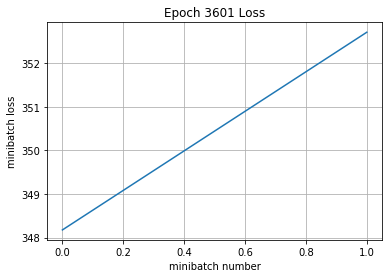

Epoch 3602, Overall loss = 0.0641, accuracy of 0.978 and f1 score of 0.98
Epoch 3603, Overall loss = 0.0638, accuracy of 0.979 and f1 score of 0.98
Epoch 3604, Overall loss = 0.0642, accuracy of 0.978 and f1 score of 0.98
Epoch 3605, Overall loss = 0.0628, accuracy of 0.977 and f1 score of 0.98
Epoch 3606, Overall loss = 0.0642, accuracy of 0.977 and f1 score of 0.98
Epoch 3607, Overall loss = 0.0643, accuracy of 0.977 and f1 score of 0.98
Epoch 3608, Overall loss = 0.0623, accuracy of 0.979 and f1 score of 0.98
Epoch 3609, Overall loss = 0.0621, accuracy of 0.979 and f1 score of 0.98
Epoch 3610, Overall loss = 0.0604, accuracy of 0.979 and f1 score of 0.98
Epoch 3611, Overall loss = 0.0676, accuracy of 0.976 and f1 score of 0.97
Epoch 3612, Overall loss = 0.0606, accuracy of 0.978 and f1 score of 0.98
Epoch 3613, Overall loss = 0.0649, accuracy of 0.978 and f1 score of 0.98
Epoch 3614, Overall loss = 0.066, accuracy of 0.976 and f1 score of 0.97
Epoch 3615, Overall loss = 0.0604, accu

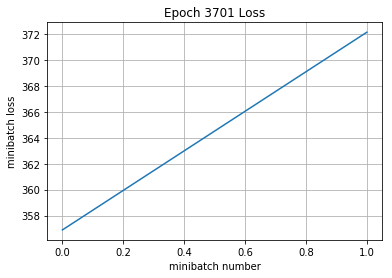

Epoch 3702, Overall loss = 0.0617, accuracy of 0.979 and f1 score of 0.98
Epoch 3703, Overall loss = 0.0621, accuracy of 0.978 and f1 score of 0.98
Epoch 3704, Overall loss = 0.0661, accuracy of 0.978 and f1 score of 0.97
Epoch 3705, Overall loss = 0.0634, accuracy of 0.978 and f1 score of 0.98
Epoch 3706, Overall loss = 0.0657, accuracy of 0.977 and f1 score of 0.97
Epoch 3707, Overall loss = 0.0647, accuracy of 0.978 and f1 score of 0.98
Epoch 3708, Overall loss = 0.0646, accuracy of 0.979 and f1 score of 0.98
Epoch 3709, Overall loss = 0.0634, accuracy of 0.977 and f1 score of 0.98
Epoch 3710, Overall loss = 0.0633, accuracy of 0.977 and f1 score of 0.98
Epoch 3711, Overall loss = 0.0616, accuracy of 0.978 and f1 score of 0.98
Epoch 3712, Overall loss = 0.0608, accuracy of 0.979 and f1 score of 0.98
Epoch 3713, Overall loss = 0.0656, accuracy of 0.978 and f1 score of 0.98
Epoch 3714, Overall loss = 0.0658, accuracy of 0.976 and f1 score of 0.98
Epoch 3715, Overall loss = 0.0634, acc

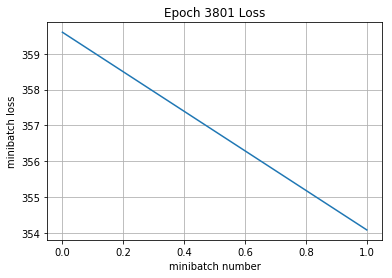

Epoch 3802, Overall loss = 0.0633, accuracy of 0.978 and f1 score of 0.98
Epoch 3803, Overall loss = 0.0622, accuracy of 0.979 and f1 score of 0.98
Epoch 3804, Overall loss = 0.0641, accuracy of 0.977 and f1 score of 0.97
Epoch 3805, Overall loss = 0.0636, accuracy of 0.977 and f1 score of 0.97
Epoch 3806, Overall loss = 0.0642, accuracy of 0.978 and f1 score of 0.98
Epoch 3807, Overall loss = 0.0609, accuracy of 0.979 and f1 score of 0.98
Epoch 3808, Overall loss = 0.0657, accuracy of 0.976 and f1 score of 0.97
Epoch 3809, Overall loss = 0.0645, accuracy of 0.978 and f1 score of 0.98
Epoch 3810, Overall loss = 0.061, accuracy of 0.977 and f1 score of 0.98
Epoch 3811, Overall loss = 0.065, accuracy of 0.978 and f1 score of 0.98
Epoch 3812, Overall loss = 0.0646, accuracy of 0.977 and f1 score of 0.98
Epoch 3813, Overall loss = 0.063, accuracy of 0.979 and f1 score of 0.98
Epoch 3814, Overall loss = 0.0627, accuracy of 0.979 and f1 score of 0.98
Epoch 3815, Overall loss = 0.0618, accura

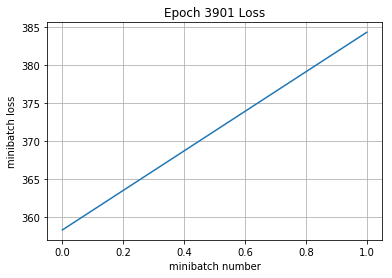

Epoch 3902, Overall loss = 0.0617, accuracy of 0.978 and f1 score of 0.98
Epoch 3903, Overall loss = 0.0633, accuracy of 0.978 and f1 score of 0.97
Epoch 3904, Overall loss = 0.0633, accuracy of 0.979 and f1 score of 0.98
Epoch 3905, Overall loss = 0.0668, accuracy of 0.977 and f1 score of 0.98
Epoch 3906, Overall loss = 0.0659, accuracy of 0.977 and f1 score of 0.98
Epoch 3907, Overall loss = 0.0648, accuracy of 0.979 and f1 score of 0.98
Epoch 3908, Overall loss = 0.0613, accuracy of 0.979 and f1 score of 0.98
Epoch 3909, Overall loss = 0.0615, accuracy of 0.978 and f1 score of 0.98
Epoch 3910, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.98
Epoch 3911, Overall loss = 0.0619, accuracy of 0.979 and f1 score of 0.98
Epoch 3912, Overall loss = 0.065, accuracy of 0.977 and f1 score of 0.97
Epoch 3913, Overall loss = 0.0661, accuracy of 0.975 and f1 score of 0.97
Epoch 3914, Overall loss = 0.0614, accuracy of 0.979 and f1 score of 0.98
Epoch 3915, Overall loss = 0.0681, accu

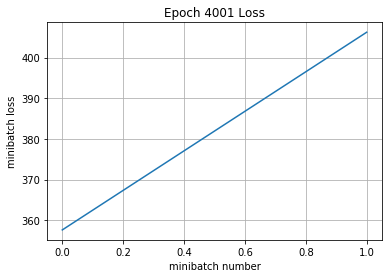

Epoch 4002, Overall loss = 0.0608, accuracy of 0.979 and f1 score of 0.98
Epoch 4003, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.98
Epoch 4004, Overall loss = 0.0659, accuracy of 0.976 and f1 score of 0.98
Epoch 4005, Overall loss = 0.063, accuracy of 0.978 and f1 score of 0.98
Epoch 4006, Overall loss = 0.0632, accuracy of 0.977 and f1 score of 0.98
Epoch 4007, Overall loss = 0.0624, accuracy of 0.979 and f1 score of 0.98
Epoch 4008, Overall loss = 0.0642, accuracy of 0.977 and f1 score of 0.98
Epoch 4009, Overall loss = 0.0643, accuracy of 0.979 and f1 score of 0.98
Epoch 4010, Overall loss = 0.0608, accuracy of 0.979 and f1 score of 0.98
Epoch 4011, Overall loss = 0.062, accuracy of 0.979 and f1 score of 0.98
Epoch 4012, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.98
Epoch 4013, Overall loss = 0.0606, accuracy of 0.978 and f1 score of 0.98
Epoch 4014, Overall loss = 0.0669, accuracy of 0.976 and f1 score of 0.97
Epoch 4015, Overall loss = 0.0624, accur

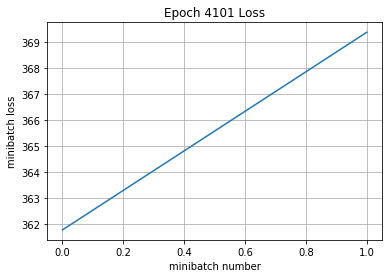

Epoch 4102, Overall loss = 0.061, accuracy of 0.978 and f1 score of 0.98
Epoch 4103, Overall loss = 0.0634, accuracy of 0.978 and f1 score of 0.98
Epoch 4104, Overall loss = 0.0615, accuracy of 0.978 and f1 score of 0.98
Epoch 4105, Overall loss = 0.0636, accuracy of 0.977 and f1 score of 0.98
Epoch 4106, Overall loss = 0.0625, accuracy of 0.978 and f1 score of 0.98
Epoch 4107, Overall loss = 0.0628, accuracy of 0.977 and f1 score of 0.98
Epoch 4108, Overall loss = 0.0627, accuracy of 0.979 and f1 score of 0.98
Epoch 4109, Overall loss = 0.0633, accuracy of 0.977 and f1 score of 0.97
Epoch 4110, Overall loss = 0.0607, accuracy of 0.978 and f1 score of 0.98
Epoch 4111, Overall loss = 0.0635, accuracy of 0.978 and f1 score of 0.98
Epoch 4112, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 4113, Overall loss = 0.0588, accuracy of 0.981 and f1 score of 0.98
Epoch 4114, Overall loss = 0.0643, accuracy of 0.977 and f1 score of 0.98
Epoch 4115, Overall loss = 0.0638, accu

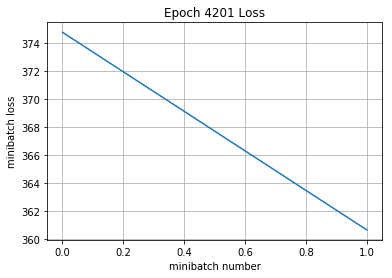

Epoch 4202, Overall loss = 0.0616, accuracy of 0.979 and f1 score of 0.98
Epoch 4203, Overall loss = 0.0621, accuracy of 0.979 and f1 score of 0.98
Epoch 4204, Overall loss = 0.0618, accuracy of 0.979 and f1 score of 0.98
Epoch 4205, Overall loss = 0.0649, accuracy of 0.978 and f1 score of 0.97
Epoch 4206, Overall loss = 0.0659, accuracy of 0.978 and f1 score of 0.98
Epoch 4207, Overall loss = 0.0619, accuracy of 0.978 and f1 score of 0.98
Epoch 4208, Overall loss = 0.0636, accuracy of 0.978 and f1 score of 0.98
Epoch 4209, Overall loss = 0.0624, accuracy of 0.979 and f1 score of 0.98
Epoch 4210, Overall loss = 0.0624, accuracy of 0.977 and f1 score of 0.98
Epoch 4211, Overall loss = 0.066, accuracy of 0.978 and f1 score of 0.98
Epoch 4212, Overall loss = 0.0632, accuracy of 0.979 and f1 score of 0.98
Epoch 4213, Overall loss = 0.061, accuracy of 0.98 and f1 score of 0.98
Epoch 4214, Overall loss = 0.0651, accuracy of 0.978 and f1 score of 0.98
Epoch 4215, Overall loss = 0.0639, accura

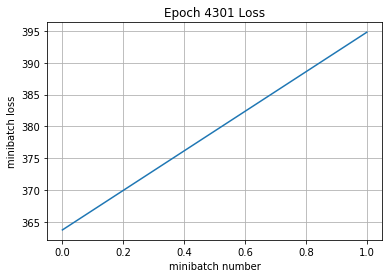

Epoch 4302, Overall loss = 0.0666, accuracy of 0.976 and f1 score of 0.97
Epoch 4303, Overall loss = 0.0605, accuracy of 0.979 and f1 score of 0.98
Epoch 4304, Overall loss = 0.0621, accuracy of 0.978 and f1 score of 0.98
Epoch 4305, Overall loss = 0.066, accuracy of 0.977 and f1 score of 0.97
Epoch 4306, Overall loss = 0.0615, accuracy of 0.979 and f1 score of 0.98
Epoch 4307, Overall loss = 0.062, accuracy of 0.979 and f1 score of 0.98
Epoch 4308, Overall loss = 0.065, accuracy of 0.977 and f1 score of 0.98
Epoch 4309, Overall loss = 0.0642, accuracy of 0.977 and f1 score of 0.98
Epoch 4310, Overall loss = 0.0652, accuracy of 0.976 and f1 score of 0.97
Epoch 4311, Overall loss = 0.0609, accuracy of 0.978 and f1 score of 0.98
Epoch 4312, Overall loss = 0.0632, accuracy of 0.979 and f1 score of 0.98
Epoch 4313, Overall loss = 0.0658, accuracy of 0.977 and f1 score of 0.98
Epoch 4314, Overall loss = 0.0639, accuracy of 0.979 and f1 score of 0.98
Epoch 4315, Overall loss = 0.0615, accura

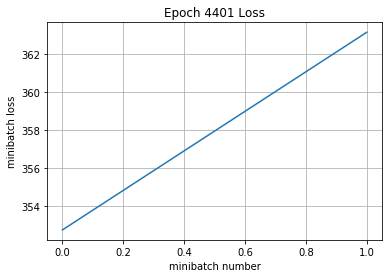

Epoch 4402, Overall loss = 0.0656, accuracy of 0.976 and f1 score of 0.97
Epoch 4403, Overall loss = 0.0612, accuracy of 0.979 and f1 score of 0.98
Epoch 4404, Overall loss = 0.0653, accuracy of 0.977 and f1 score of 0.98
Epoch 4405, Overall loss = 0.0629, accuracy of 0.977 and f1 score of 0.98
Epoch 4406, Overall loss = 0.0624, accuracy of 0.978 and f1 score of 0.98
Epoch 4407, Overall loss = 0.0634, accuracy of 0.977 and f1 score of 0.98
Epoch 4408, Overall loss = 0.0616, accuracy of 0.978 and f1 score of 0.98
Epoch 4409, Overall loss = 0.0614, accuracy of 0.979 and f1 score of 0.98
Epoch 4410, Overall loss = 0.0655, accuracy of 0.976 and f1 score of 0.97
Epoch 4411, Overall loss = 0.062, accuracy of 0.978 and f1 score of 0.98
Epoch 4412, Overall loss = 0.063, accuracy of 0.979 and f1 score of 0.98
Epoch 4413, Overall loss = 0.0616, accuracy of 0.979 and f1 score of 0.98
Epoch 4414, Overall loss = 0.0583, accuracy of 0.982 and f1 score of 0.98
Epoch 4415, Overall loss = 0.06, accurac

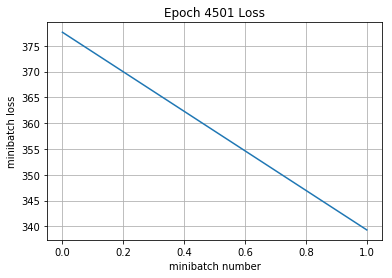

Epoch 4502, Overall loss = 0.0604, accuracy of 0.978 and f1 score of 0.98
Epoch 4503, Overall loss = 0.0636, accuracy of 0.977 and f1 score of 0.98
Epoch 4504, Overall loss = 0.0638, accuracy of 0.977 and f1 score of 0.98
Epoch 4505, Overall loss = 0.0633, accuracy of 0.978 and f1 score of 0.98
Epoch 4506, Overall loss = 0.0603, accuracy of 0.979 and f1 score of 0.98
Epoch 4507, Overall loss = 0.0606, accuracy of 0.979 and f1 score of 0.98
Epoch 4508, Overall loss = 0.0623, accuracy of 0.979 and f1 score of 0.98
Epoch 4509, Overall loss = 0.0626, accuracy of 0.978 and f1 score of 0.98
Epoch 4510, Overall loss = 0.0611, accuracy of 0.978 and f1 score of 0.98
Epoch 4511, Overall loss = 0.0629, accuracy of 0.978 and f1 score of 0.98
Epoch 4512, Overall loss = 0.0658, accuracy of 0.975 and f1 score of 0.97
Epoch 4513, Overall loss = 0.0615, accuracy of 0.978 and f1 score of 0.98
Epoch 4514, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.97
Epoch 4515, Overall loss = 0.0603, acc

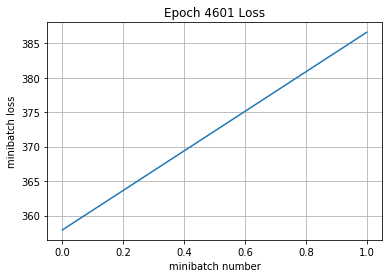

Epoch 4602, Overall loss = 0.0638, accuracy of 0.977 and f1 score of 0.98
Epoch 4603, Overall loss = 0.0627, accuracy of 0.977 and f1 score of 0.97
Epoch 4604, Overall loss = 0.0609, accuracy of 0.978 and f1 score of 0.98
Epoch 4605, Overall loss = 0.0624, accuracy of 0.98 and f1 score of 0.98
Epoch 4606, Overall loss = 0.0648, accuracy of 0.977 and f1 score of 0.98
Epoch 4607, Overall loss = 0.0624, accuracy of 0.977 and f1 score of 0.98
Epoch 4608, Overall loss = 0.0674, accuracy of 0.975 and f1 score of 0.97
Epoch 4609, Overall loss = 0.0648, accuracy of 0.978 and f1 score of 0.98
Epoch 4610, Overall loss = 0.0644, accuracy of 0.977 and f1 score of 0.98
Epoch 4611, Overall loss = 0.0615, accuracy of 0.979 and f1 score of 0.98
Epoch 4612, Overall loss = 0.0641, accuracy of 0.978 and f1 score of 0.98
Epoch 4613, Overall loss = 0.0626, accuracy of 0.975 and f1 score of 0.97
Epoch 4614, Overall loss = 0.0644, accuracy of 0.977 and f1 score of 0.97
Epoch 4615, Overall loss = 0.0619, accu

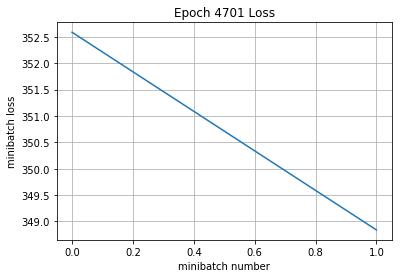

Epoch 4702, Overall loss = 0.0615, accuracy of 0.979 and f1 score of 0.98
Epoch 4703, Overall loss = 0.0616, accuracy of 0.978 and f1 score of 0.98
Epoch 4704, Overall loss = 0.0593, accuracy of 0.98 and f1 score of 0.98
Epoch 4705, Overall loss = 0.0628, accuracy of 0.978 and f1 score of 0.98
Epoch 4706, Overall loss = 0.0612, accuracy of 0.977 and f1 score of 0.97
Epoch 4707, Overall loss = 0.0605, accuracy of 0.979 and f1 score of 0.98
Epoch 4708, Overall loss = 0.0609, accuracy of 0.98 and f1 score of 0.98
Epoch 4709, Overall loss = 0.0607, accuracy of 0.979 and f1 score of 0.98
Epoch 4710, Overall loss = 0.0649, accuracy of 0.978 and f1 score of 0.98
Epoch 4711, Overall loss = 0.0629, accuracy of 0.978 and f1 score of 0.98
Epoch 4712, Overall loss = 0.0637, accuracy of 0.979 and f1 score of 0.98
Epoch 4713, Overall loss = 0.0634, accuracy of 0.978 and f1 score of 0.98
Epoch 4714, Overall loss = 0.0608, accuracy of 0.978 and f1 score of 0.98
Epoch 4715, Overall loss = 0.0623, accur

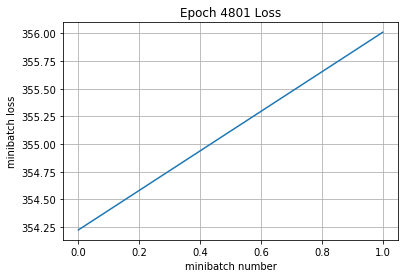

Epoch 4802, Overall loss = 0.0627, accuracy of 0.979 and f1 score of 0.98
Epoch 4803, Overall loss = 0.0639, accuracy of 0.977 and f1 score of 0.98
Epoch 4804, Overall loss = 0.0584, accuracy of 0.979 and f1 score of 0.98
Epoch 4805, Overall loss = 0.0635, accuracy of 0.977 and f1 score of 0.98
Epoch 4806, Overall loss = 0.0631, accuracy of 0.978 and f1 score of 0.98
Epoch 4807, Overall loss = 0.0627, accuracy of 0.977 and f1 score of 0.98
Epoch 4808, Overall loss = 0.0619, accuracy of 0.978 and f1 score of 0.98
Epoch 4809, Overall loss = 0.0624, accuracy of 0.978 and f1 score of 0.98
Epoch 4810, Overall loss = 0.0633, accuracy of 0.977 and f1 score of 0.98
Epoch 4811, Overall loss = 0.0663, accuracy of 0.977 and f1 score of 0.97
Epoch 4812, Overall loss = 0.0612, accuracy of 0.979 and f1 score of 0.98
Epoch 4813, Overall loss = 0.0606, accuracy of 0.979 and f1 score of 0.98
Epoch 4814, Overall loss = 0.0611, accuracy of 0.979 and f1 score of 0.98
Epoch 4815, Overall loss = 0.0607, acc

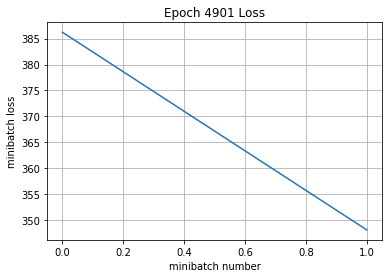

Epoch 4902, Overall loss = 0.0596, accuracy of 0.978 and f1 score of 0.98
Epoch 4903, Overall loss = 0.0643, accuracy of 0.977 and f1 score of 0.97
Epoch 4904, Overall loss = 0.0602, accuracy of 0.98 and f1 score of 0.98
Epoch 4905, Overall loss = 0.0632, accuracy of 0.978 and f1 score of 0.98
Epoch 4906, Overall loss = 0.061, accuracy of 0.978 and f1 score of 0.98
Epoch 4907, Overall loss = 0.0639, accuracy of 0.978 and f1 score of 0.98
Epoch 4908, Overall loss = 0.0632, accuracy of 0.977 and f1 score of 0.98
Epoch 4909, Overall loss = 0.0643, accuracy of 0.977 and f1 score of 0.98
Epoch 4910, Overall loss = 0.0637, accuracy of 0.978 and f1 score of 0.97
Epoch 4911, Overall loss = 0.0671, accuracy of 0.974 and f1 score of 0.97
Epoch 4912, Overall loss = 0.0624, accuracy of 0.978 and f1 score of 0.98
Epoch 4913, Overall loss = 0.063, accuracy of 0.977 and f1 score of 0.97
Epoch 4914, Overall loss = 0.0606, accuracy of 0.979 and f1 score of 0.98
Epoch 4915, Overall loss = 0.0627, accura

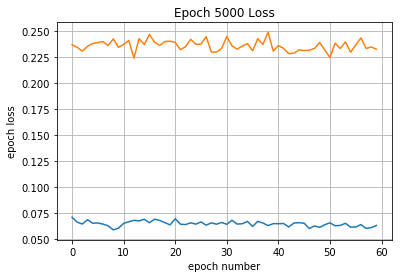

Training finished !
Validation loss, Overall loss = 0.237, accuracy of 0.927 and f1 score of 0.926


In [10]:
# properties
# General
# TODO : declare additional properties
# not fixed (change or add property as you like)
batch_size = 5800
epoch_num = 5000
print_every = 100

# fixed
# True if you want to train, False if you already trained your model
# TODO : IMPORTANT !!! Please change it to False when you submit your code
is_train_mode = True
train_validation = True
validation = True
# TODO : IMPORTANT !!! Please specify the path where your best model is saved
# example : checkpoint/run-0925-0348
checkpoint_path = 'checkpoint/fc_1024_mix_18'

# X, y, mean_loss,correct_prediction,train_step, accuracy = my_model(lr = 2e-4, rl = 1e-4,  is_training= is_train_mode)
#load data

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint_path)			
    if is_train_mode:
        variables = [mean_loss,correct_prediction, y_out, train_step]
        iter_cnt = 0
        best_loss = 1000
        for e in range(epoch_num):                   
            train_indicies = np.arange(Xd.shape[0])
            np.random.shuffle(train_indicies)
            correct = 0
            losses = []
            f1_scores = []
            for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                start_idx = (i*batch_size)%Xd.shape[0]
                idx = train_indicies[start_idx:start_idx+batch_size]
                feed_dict = {X: Xd[idx,:],
                             y: yd[idx] }
                actual_batch_size = yd[idx].shape[0]
                loss, corr, y_outs, _ = sess.run(variables,feed_dict=feed_dict)
                losses.append(loss*actual_batch_size)
                correct += np.sum(corr)
                f1_score = calculate_average_F1_score(from_eight(onehot(y_outs)), from_eight(yd[idx]))
                f1_scores.append(f1_score*actual_batch_size)
                if is_train_mode and (iter_cnt % print_every) == 0:
                    print("Iteration {0}: with minibatch training loss = {1:.3g}, accuracy of {2:.2g}, and f1 score of {3:.2g}"\
                          .format(iter_cnt,loss,np.sum(corr)/actual_batch_size, f1_score))
                iter_cnt += 1
            total_correct = correct/Xd.shape[0]
            total_loss = np.sum(losses)/Xd.shape[0]
            total_f1 = np.sum(f1_scores)/Xd.shape[0]
            print("Epoch {2}, Overall loss = {0:.3g}, accuracy of {1:.3g} and f1 score of {3:.2g}"\
              .format(total_loss,total_correct,e+1, total_f1))
            if (e % 100 == 0) and  train_validation:
                train_losses.append(total_loss)
                correct_val = 0
                losses_val = []
                f1s_val = []
                val_indicies = np.arange(Xd_val.shape[0])
                for j in range(int(math.ceil(Xd_val.shape[0]/batch_size))):
                    start_idx = (j*batch_size)%Xd_val.shape[0]
                    idx = val_indicies[start_idx:start_idx+batch_size]
                    feed_dict_val = {X: Xd_val[idx, :],
                                 y: yd_val[idx] }
                    actual_batch_size = yd_val[idx].shape[0]
                    val_loss, val_corr, y_out_val = sess.run([mean_loss, correct_prediction, y_out] ,feed_dict=feed_dict_val)
                    losses_val.append(val_loss*actual_batch_size)
                    correct_val += np.sum(val_corr)
                    f1_score_val = calculate_average_F1_score(from_eight(onehot(y_out_val)), from_eight(yd_val[idx]))
                    f1s_val.append(f1_score_val*actual_batch_size)
                total_val_loss = np.sum(losses_val)/Xd_val.shape[0]
                total_val_correct = correct_val/Xd_val.shape[0]
                val_losses.append(total_val_loss)
                val_f1 = np.sum(f1s_val)/Xd_val.shape[0]
                print("Validation loss, Overall loss = {0:.3g}, accuracy of {1:.3g} and f1 score of {2:.3g}".format(total_val_loss, total_val_correct, val_f1))        
                plt.plot(losses)
                plt.grid(True)
                plt.title('Epoch {} Loss'.format(e+1))
                plt.xlabel('minibatch number')
                plt.ylabel('minibatch loss')
                plt.show()
                if total_val_loss < best_loss:
                    best_loss = total_val_loss
             #         output_dir = checkpoint_path + '/run-%02d%02d-%02d%02d' % tuple(localtime(time()))[1:5]
                    output_dir = checkpoint_path
                    if not gfile.Exists(output_dir):
                        gfile.MakeDirs(output_dir)
                    saver.save(sess, output_dir)
                    print('Model saved in file : %s' % output_dir)             
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(epoch_num))
        plt.xlabel('epoch number')
        plt.ylabel('epoch loss')
        plt.show()                    
        print('Training finished !')


    if validation:
        correct = 0
        losses = []
        f1s_val = []
        val_indicies = np.arange(Xd_val.shape[0])
        for j in range(int(math.ceil(Xd_val.shape[0]/batch_size))):
            start_idx = (j*batch_size)%Xd_val.shape[0]
            idx = val_indicies[start_idx:start_idx+batch_size]
            feed_dict_val = {X: Xd_val[idx, :],
                         y: yd_val[idx] }
            actual_batch_size = yd_val[idx].shape[0]
            loss, corr, y_out_val = sess.run([mean_loss, correct_prediction, y_out],feed_dict=feed_dict_val)
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            f1_score_val = calculate_average_F1_score(from_eight(onehot(y_out_val)), from_eight(yd_val[idx]))
            f1s_val.append(f1_score_val*actual_batch_size)
        total_val_correct = correct/Xd_val.shape[0]
        total_val_loss = np.sum(losses)/Xd_val.shape[0]
        val_f1 = np.sum(f1s_val)/Xd_val.shape[0]
        print("Validation loss, Overall loss = {0:.3g}, accuracy of {1:.3g} and f1 score of {2:.3g}"\
          .format(total_val_loss,total_val_correct, val_f1))


In [ ]:
sum(yd_val)/sum(sum(yd_val))

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.grid(True)
plt.title('Epoch {} Loss'.format(epoch_num))
plt.xlabel('epoch number')
plt.ylabel('epoch loss')
plt.show()                 